# Task 2: Understanding Vision Transformers (ViT)

## original attention map

In [16]:
import torch
import numpy as np
from math import sqrt
from PIL import Image, ImageFilter
import matplotlib.pyplot as plt
from transformers import ViTForImageClassification, ViTImageProcessor

# NOTE: assumes `model`, `processor`, `inputs`, `img`, and `DEVICE` already exist from your original code
MODEL_NAME = "google/vit-base-patch16-224"
IMAGE_PATH = "./dog.jpeg"    
DEVICE = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

model = ViTForImageClassification.from_pretrained(
    MODEL_NAME,
    attn_implementation="eager" # to return attentions        
).to(DEVICE)
processor = ViTImageProcessor.from_pretrained(MODEL_NAME)
model.eval()

img = Image.open(IMAGE_PATH).convert("RGB")
inputs = processor(images=img, return_tensors="pt").to(DEVICE)

def get_rollout_from_attentions(attentions):
    tokens = attentions[0].size(-1)
    rollout = torch.eye(tokens).to(DEVICE)
    for layer_attn in attentions:
        attn_heads_fused = layer_attn[0].mean(dim=0)
        attn_heads_fused = attn_heads_fused + torch.eye(tokens).to(DEVICE)
        attn_heads_fused = attn_heads_fused / attn_heads_fused.sum(dim=-1, keepdim=True)
        rollout = attn_heads_fused @ rollout
    return rollout  # shape [tokens, tokens]

def plot_attention_overlay(attn_map, pil_img, title="Attention Overlay"):
    # Resize to image size
    attn_map_resized = np.array(Image.fromarray(attn_map).resize(pil_img.size, resample=Image.BILINEAR))
    fig, ax = plt.subplots(figsize=(6,6))
    ax.imshow(pil_img)
    ax.imshow(attn_map_resized, cmap='jet', alpha=0.3)
    ax.axis("off")
    plt.title(title)
    plt.tight_layout()
    plt.show()

def run_vit_attention(input_tensors, pil_img, title_prefix=""):
    with torch.no_grad():
        outputs = model(**input_tensors, output_attentions=True)
    logits = outputs.logits
    pred_idx = int(logits.argmax(-1).item())
    pred_label = model.config.id2label[pred_idx]
    rollout = get_rollout_from_attentions(outputs.attentions)
    # CLS -> patch attention vector
    cls_attn = rollout[0, 1:]  # excludes CLS token itself
    num_patches = cls_attn.shape[0]
    side = int(sqrt(num_patches))
    attn_map = cls_attn.reshape(side, side).cpu().numpy()
    # normalize to 0-255 for plotting 
    attn_map = (attn_map - attn_map.min()) / (attn_map.max() - attn_map.min() + 1e-12)
    print(f"{title_prefix}Prediction: {pred_label} (idx={pred_idx})")
    plot_attention_overlay(attn_map, pil_img, title=f"{title_prefix} Prediction: {pred_label}")
    return pred_label, rollout

Original: Prediction: golden retriever (idx=207)


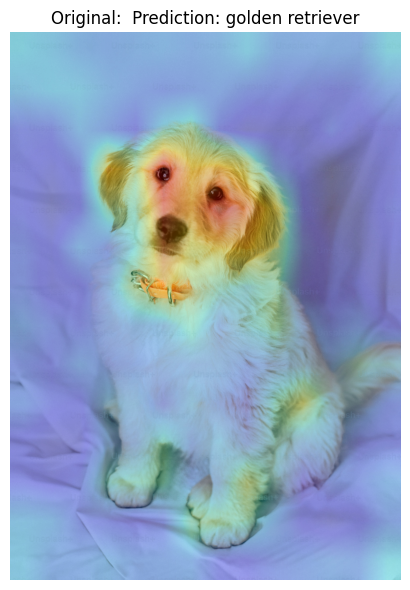

In [7]:
orig_pred, orig_rollout = run_vit_attention(inputs, img, title_prefix="Original: ")


Did ViT focus on the object?
- yes it did as the heatmap outlines the dog’s figure → that’s a good sign: the model bases its prediction on the actual object.

Comparison with CNNs (CAM / Grad-CAM):
- CNNs use convolutional feature maps and you need post-hoc tools (like Grad-CAM) to visualize where the model “looked.”
- ViTs have built-in attention weights, making interpretability more “native.” You don’t need gradients for a rough explanation.
- Advantage: ViTs allow inspection at multiple layers/heads, giving richer interpretability than a single activation map from CNNs.

Peculiar behavior:
- Sometimes attention latches onto irrelevant areas (like borders, background textures) as for my pictures, sometimes the background colour resembles that off the dog's fur, so it attends to areas closer and similar in colour to the dog's fur as well

Different attention heads often specialize:
- Some heads focus locally (edges, textures).
- Others focus globally (whole object or context).
- one can tell by inspecting head-specific maps — some will highlight small details, others broader regions which i did for ATML summer PA1 bert analysis

## masking patches

In [42]:
def mask_patches(inputs_dict, mask_type="random", mask_fraction=0.3, patch_size=16):
    pixel_values = inputs_dict["pixel_values"].clone()  # shape [B, C, H, W], B usually 1
    B, C, H, W = pixel_values.shape
    side = H // patch_size
    num_patches = side * side

    if mask_type == "random":
        num_mask = int(np.round(mask_fraction * num_patches))
        mask_idx = np.random.choice(num_patches, size=num_mask, replace=False)
    elif mask_type == "center":
        num_mask = int(np.round(mask_fraction * num_patches))
        center = side // 2

        # all patches with distance from center
        patch_coords = [(r, c) for r in range(side) for c in range(side)]
        patch_dists = [abs(r - center) + abs(c - center) for r, c in patch_coords]

        # sort by closeness to center
        sorted_idx = np.argsort(patch_dists)

        # pick closest num_mask patches
        mask_idx = [patch_coords[i][0] * side + patch_coords[i][1] for i in sorted_idx[:num_mask]]

    else:
        raise ValueError("mask_type must be 'random' or 'center'")

    for idx in mask_idx:
        r, c = divmod(int(idx), side)
        rs, cs = r * patch_size, c * patch_size
        pixel_values[:, :, rs:rs+patch_size, cs:cs+patch_size] = 0.0

    return {"pixel_values": pixel_values.to(DEVICE)}

In [46]:
def run_masking_tests(inputs, pil_img):
    # Random mask
    random_inputs = mask_patches(inputs, mask_type="random", mask_fraction=0.3)
    run_vit_attention(random_inputs, pil_img, title_prefix="Random Mask (30%): ")

    # Center mask
    center_inputs = mask_patches(inputs, mask_type="center", mask_fraction=0.3)
    run_vit_attention(center_inputs, pil_img, title_prefix="Center Mask: ")

Random Mask (30%): Prediction: golden retriever (idx=207)


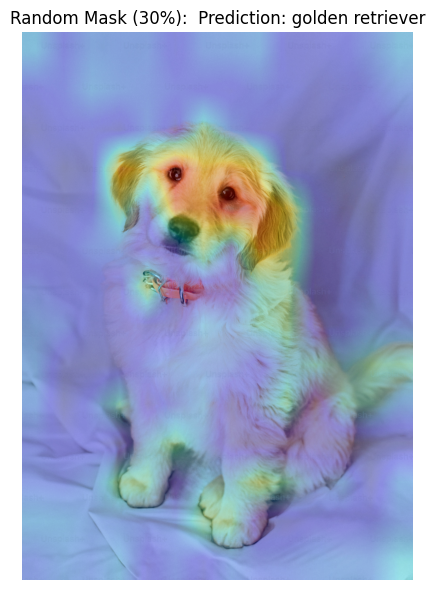

Center Mask: Prediction: Labrador retriever (idx=208)


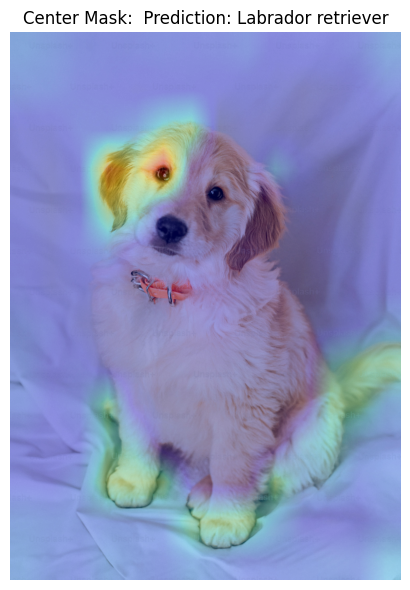

In [47]:
run_masking_tests(inputs, img)


Random masking:
- If you randomly mask 10–30% of patches, ViT usually handles it fairly well (accuracy drops only slightly).
- This robustness comes from pretraining objectives like Masked Image Modeling (MIM) (used in MAE, BEiT, etc.), where ViTs learn to reconstruct missing patches.
- ViT inductive bias: Vision Transformers already train with dropout-like stochasticity on tokens, so losing scattered tokens is something the model can interpolate around.
- Global self-attention: Remaining patches still “see” each other across the full spatial grid, so the model can reconstruct context from neighbors around the holes.
- Perceptual redundancy: Natural images are highly redundant — a dog’s fur or the sky looks similar across many patches. Losing some random ones doesn’t remove all information about any one semantic region.

Structured masking (center mask):

- If you mask the center (where the object usually is), performance drops much more than random masking.
- This shows that ViT predictions heavily depend on object-centric patches (whereas background masking is less harmful).
- Contiguous damage: Unlike random, center masking wipes out a block of neighboring patches. Self-attention can’t “guess” what’s there from scattered context because an entire local region is missing.
- Attention collapse: ViT attention heads often anchor on central tokens and global CLS token. When that anchor region is missing, the attention maps flatten or spread unnaturally 
- No redundancy in the middle: Losing patches at the edges still leaves the object intact. Losing the middle is like cutting out the subject of the image

Conclusion: ViTs are robust to random missing data (like dropout for images), but sensitive to semantically important regions being masked.

## cls vs mean attention

In [10]:
def plot_cls_vs_mean_attention(inputs_dict, pil_img, title_prefix="CLS vs Mean"):
    with torch.no_grad():
        outputs = model(**inputs_dict, output_attentions=True)
    logits = outputs.logits
    pred_idx = int(logits.argmax(-1).item())
    pred_label = model.config.id2label[pred_idx]
    rollout = get_rollout_from_attentions(outputs.attentions)
    num_patches = rollout.size(-1) - 1
    side = int(sqrt(num_patches))

    # CLS map
    cls_map = rollout[0, 1:].cpu().numpy()
    cls_map = (cls_map - cls_map.min()) / (cls_map.max() - cls_map.min() + 1e-12)
    cls_map = cls_map.reshape(side, side)

    # Mean-patch map (average attention distribution of patch tokens)
    mean_map = rollout[1:, 1:].mean(dim=0).cpu().numpy()
    mean_map = (mean_map - mean_map.min()) / (mean_map.max() - mean_map.min() + 1e-12)
    mean_map = mean_map.reshape(side, side)

    # Plot side-by-side
    fig, axes = plt.subplots(1, 2, figsize=(12,6))
    axes[0].imshow(pil_img); axes[0].imshow(np.array(Image.fromarray(cls_map).resize(pil_img.size)), cmap='jet', alpha=0.3)
    axes[0].axis("off"); axes[0].set_title(f"{title_prefix} - CLS (Pred: {pred_label})")
    axes[1].imshow(pil_img); axes[1].imshow(np.array(Image.fromarray(mean_map).resize(pil_img.size)), cmap='jet', alpha=0.3)
    axes[1].axis("off"); axes[1].set_title(f"{title_prefix} - MeanPatch (Pred: {pred_label})")
    plt.tight_layout(); plt.show()

    print(f"{title_prefix} Prediction: {pred_label} (idx={pred_idx})")
    return pred_label, cls_map, mean_map

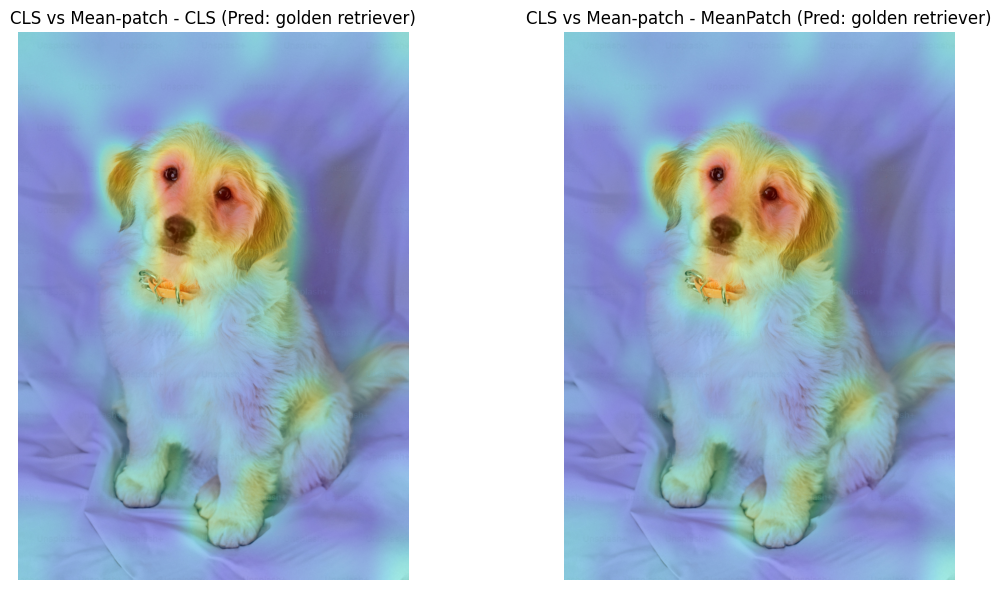

CLS vs Mean-patch Prediction: golden retriever (idx=207)


('golden retriever',
 array([[0.34400588, 0.31064877, 0.25660887, 0.23225857, 0.24723391,
         0.26002616, 0.23726186, 0.2640103 , 0.33289087, 0.24601729,
         0.2394336 , 0.2452083 , 0.23556209, 0.35258415],
        [0.29296604, 0.32426357, 0.3266123 , 0.26216057, 0.21756136,
         0.18591195, 0.20767866, 0.22719699, 0.17640628, 0.1588419 ,
         0.1573114 , 0.13585123, 0.15512387, 0.22437221],
        [0.14626224, 0.14736214, 0.27342725, 0.20584038, 0.12229474,
         0.35022914, 0.42298704, 0.14316393, 0.06504196, 0.08517756,
         0.08035463, 0.16392109, 0.08805347, 0.12899333],
        [0.13094506, 0.08746776, 0.15134068, 0.6857706 , 0.53895694,
         1.        , 0.6551222 , 0.7087952 , 0.56387895, 0.20372036,
         0.11008334, 0.        , 0.06355517, 0.10294265],
        [0.1302268 , 0.04509858, 0.1207615 , 0.44569415, 0.40588486,
         0.8724503 , 0.7196437 , 0.96798414, 0.8017094 , 0.5706866 ,
         0.13270807, 0.02146258, 0.04483407, 0.14327699],

In [11]:
plot_cls_vs_mean_attention(inputs, img, title_prefix="CLS vs Mean-patch")

CLS token probe:
- The [CLS] token is trained during pretraining to aggregate information across patches.
- Works very well if the pretraining included a supervised objective (e.g., ImageNet classification).

Mean pooling probe (average over patch embeddings):
- Works better in self-supervised pretraining (MIM, contrastive), where the CLS token may not be explicitly optimized.
- Averaging patch embeddings ensures global context without relying on CLS specialization.

Which performs better?
- Supervised ViT (like mine) → CLS token probe usually outperforms mean pooling.
- Self-supervised ViT → mean pooling often works better, since patch embeddings carry more distributed semantic information.

Interaction with objectives:
- CLS pooling is aligned with classification pretraining.
- Mean pooling is more aligned with representation learning / reconstruction pretraining.